In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Especifica la ruta al archivo CSV
path = r'C:\\Users\\joset\\OneDrive\\Documentos\\Master Big Data UCM\\18-TFN\NaturgyProject\\data'
provincias_temperaturas_promedio = pd.read_csv(path + '\\Cleaning\\provincias_temperaturas_promedio.csv', encoding = 'latin1')
provincia_coef_mes=pd.read_csv(path + '\\Cleaning\\provincia_coef_mes.csv', encoding = 'latin1')


In [3]:
provincias_temperaturas_promedio.head(3)

,NOM_PROV,FECHA,MAX,MIN
0,A CORUÃA,2009-01-01,15.35,10.8
1,PALENCIA,2009-01-01,9.00,2.5
2,BARCELONA,2009-01-01,13.40,7.9


In [4]:
provincia_coef_mes.rename(columns={'AÃO_MES': 'AÑO_MES'}, inplace=True)
provincia_coef_mes.head(3)

,PROVINCIA,AÑO_MES,Consumo_kWh,%_Consumo
0,A CORUÃA,2021-10,10695536.73,1.84
1,A CORUÃA,2021-11,24993254.09,1.38
2,A CORUÃA,2021-12,31367381.77,1.37


In [5]:
def calcular_temperaturas_diarias_ponderadas(df_temperaturas, df_coef_consumo):
    """
    Calcula las temperaturas máximas y mínimas ponderadas por día utilizando el coeficiente de consumo.

    Parámetros:
    df_temperaturas (pandas.DataFrame): DataFrame con columnas 'NOM_PROV', 'FECHA', 'MAX', 'MIN'.
    df_coef_consumo (pandas.DataFrame): DataFrame con columnas 'PROVINCIA', 'AÑO_MES', '%_Consumo'.

    Retorna:
    pandas.DataFrame: DataFrame con las temperaturas máximas y mínimas ponderadas por día.
    """
    # Asegurarse de que la columna FECHA esté en formato de fecha
    df_temperaturas['FECHA'] = pd.to_datetime(df_temperaturas['FECHA'])
    
    # Crear la columna AÑO_MES en el dataset df_temperaturas
    df_temperaturas['AÑO_MES'] = df_temperaturas['FECHA'].dt.to_period('M').astype(str)
    
    # Renombrar la columna si existe un nombre mal codificado
    df_coef_consumo.rename(columns={'AÃO_MES': 'AÑO_MES'}, inplace=True)
    
    # Combinar los dos datasets basados en provincia y AÑO_MES
    df_combined = pd.merge(df_temperaturas, df_coef_consumo, left_on=['NOM_PROV', 'AÑO_MES'], right_on=['PROVINCIA', 'AÑO_MES'])
    
    # Calcular las temperaturas ponderadas
    df_combined['Temp_Ponderada_MAX'] = df_combined['MAX'] * df_combined['%_Consumo']/100
    df_combined['Temp_Ponderada_MIN'] = df_combined['MIN'] * df_combined['%_Consumo']/100
    
    # Agrupar por fecha para obtener las temperaturas diarias ponderadas
    df_temperatura_diaria_ponderada = df_combined.groupby('FECHA').agg({
        'Temp_Ponderada_MAX': 'sum',
        'Temp_Ponderada_MIN': 'sum'
    }).reset_index()

        # Redondear las temperaturas ponderadas a dos decimales
    df_temperatura_diaria_ponderada['Temp_Ponderada_MAX'] = df_temperatura_diaria_ponderada['Temp_Ponderada_MAX'].round(2)
    df_temperatura_diaria_ponderada['Temp_Ponderada_MIN'] = df_temperatura_diaria_ponderada['Temp_Ponderada_MIN'].round(2)
    
    return df_temperatura_diaria_ponderada

In [6]:
# Aplicar la función a tus datasets
resultado_temperaturas_diarias_ponderadas = calcular_temperaturas_diarias_ponderadas(provincias_temperaturas_promedio, provincia_coef_mes)
# Verificar los primeros resultados
resultado_temperaturas_diarias_ponderadas.head(5)

,FECHA,Temp_Ponderada_MAX,Temp_Ponderada_MIN
0,2021-10-01,25.06,14.28
1,2021-10-02,24.99,14.30
2,2021-10-03,22.50,13.00
3,2021-10-04,19.24,10.54
4,2021-10-05,23.24,11.10


In [7]:
resultado_temperaturas_diarias_ponderadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FECHA               1004 non-null   datetime64[ns]
 1   Temp_Ponderada_MAX  1004 non-null   float64       
 2   Temp_Ponderada_MIN  1004 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.7 KB


In [8]:
resultado_temperaturas_diarias_ponderadas.describe()

,FECHA,Temp_Ponderada_MAX,Temp_Ponderada_MIN
count,1004,1004.000000,1004.000000
mean,2023-02-14 11:59:59.999999744,21.052161,10.925677
min,2021-10-01 00:00:00,6.720000,-1.010000
25%,2022-06-08 18:00:00,15.145000,5.927500
50%,2023-02-14 12:00:00,20.380000,10.200000
75%,2023-10-23 06:00:00,26.610000,16.075000
max,2024-06-30 00:00:00,36.900000,23.980000
std,NaN,6.794730,6.114497


In [9]:
#Guardamos nuestro dataset por si lo necesitamos mas adelante
resultado_temperaturas_diarias_ponderadas.to_csv(path + '\\Cleaning\\resultado_temperaturas_diarias_ponderadas.csv', index=False)

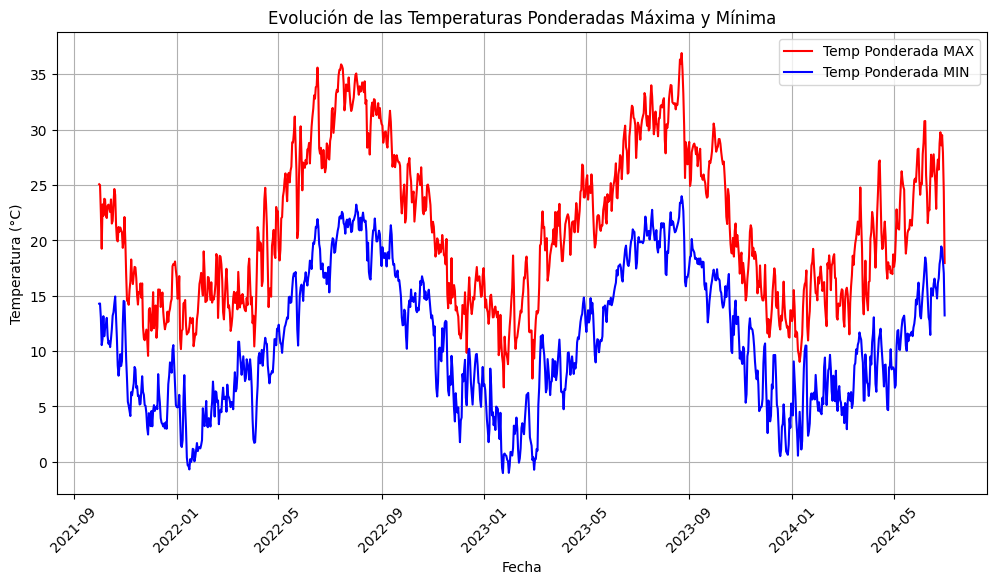

In [10]:
# Crear el gráfico de líneas para la evolución de Temp_Ponderada_MAX y Temp_Ponderada_MIN
plt.figure(figsize=(12, 6))
# Graficar la temperatura máxima ponderada
plt.plot(resultado_temperaturas_diarias_ponderadas['FECHA'], 
         resultado_temperaturas_diarias_ponderadas['Temp_Ponderada_MAX'], 
         label='Temp Ponderada MAX', color='red')
# Graficar la temperatura mínima ponderada
plt.plot(resultado_temperaturas_diarias_ponderadas['FECHA'], 
         resultado_temperaturas_diarias_ponderadas['Temp_Ponderada_MIN'], 
         label='Temp Ponderada MIN', color='blue')
# Añadir título y etiquetas
plt.title('Evolución de las Temperaturas Ponderadas Máxima y Mínima')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)
# Añadir una cuadrícula
plt.grid(True)
# Añadir una leyenda
plt.legend()
# Mostrar el gráfico
plt.show()
